In [1]:
import torch
import torch.nn as nn
from helchriss.utils import stprint

# Domain Definition
create function domains and evaluate using executor.

In [2]:
from domains.math.integer_domain import integer_executor
r_int = integer_executor.evaluate("plus(one(), two())", {})
stprint(r_int)

from domains.spatial.circle_domain import circle_executor
r_circ = circle_executor.evaluate("area(unit_circle())", {})
stprint(r_circ)

29 14:22:01 Function one automatically registered.
29 14:22:01 Function two automatically registered.
29 14:22:01 Function three automatically registered.
29 14:22:01 Function plus automatically registered.
29 14:22:01 Function avg automatically registered.
29 14:22:01 Function smaller automatically registered.
29 14:22:01 Function bigger automatically registered.
29 14:22:01 Function N automatically registered.
29 14:22:01 Function Z automatically registered.
29 14:22:01 Function subset automatically registered.
29 14:22:01 Function unit_circle automatically registered.
29 14:22:01 Function area automatically registered.
29 14:22:01 Function disconnected automatically registered.
29 14:22:01 Function externally_connected automatically registered.
29 14:22:01 Function partial_overlap automatically registered.
29 14:22:01 Function equal automatically registered.
29 14:22:01 Function tangential_proper_part automatically registered.
29 14:22:01 Function non_tangential_proper_part automati

r_int = Value:[3.0000]-float P:[1.0] (Value)
r_circ = Value:[tensor([3.1416])]-float P:[1.0] (Value)


# Rewrite Rules
   1. a `LocalFrame` module is several rewrite rules that shares the same arg writer.
   2. a NeuralRewriter module compose of a dictionary of LocalFrame.

In [3]:
from core.metaphors.rewrite import NeuralRewriter, LocalFrame
rewriter = NeuralRewriter()
#frame = LocalFrame()
#rewriter.add_frame("rw", frame)

# Rewrite Executor
**Property**
1) it stores a `ExecutorGroup` that can look up domain functions.
2) a rewriter of class `NeuralRewriter`, is stores all the rewrite rules learned.

**Methods**
1) `evaluate(expr, grounding)` method takes a expression and grounding as input, then calculate the exepected output of an expression over all rewrite rules. The output should be a single value as the exepected output.
2) `infer_rewrite` method takes an expression (and grounding) as input and propose several rewrite rules

In [4]:
from core.metaphors.executor import ExecutorGroup, RewriteExecutor
from helchriss.knowledge.symbolic import Expression
executor = RewriteExecutor(ExecutorGroup([circle_executor, integer_executor]))
result = executor.evaluate("plus:Integer(one:Integer(), two:Integer())", {})
print(result)

from helchriss.dsl.dsl_types import AnyType
#executor.base_executor.register_function("idd", [AnyType],AnyType, nn.Identity())

expr = "partial_overlap:Circle(N:Integer(), unit_circle:Circle())"
expr = Expression.parse_program_string(expr)
hypothesis = executor.infer_rewrite_expr(expr)
stprint(hypothesis)
executor.add_metaphors(hypothesis) ### add rewrite exprs


executor.evaluate(expr, grounding = {})


29 14:22:01 WRN The input domain is empty, creating an empty domain
29 14:22:01 WRN The input domain is empty, creating an empty domain


Value:[3.0000]-float P:[1.0]
hypothesis = list (length: 1)[
  list (length: 4)[
    0: 'partial_overlap:Circle'
    list (length: 2)[
      0: Embedding[circle, 3] (EmbeddingType)
      1: Embedding[circle, 3] (EmbeddingType)
    ]
    list (length: 2)[
      0: Embedding[set, 32] (EmbeddingType)
      1: Embedding[circle, 3] (EmbeddingType)
    ]
    3: bool (TypeBase)
  ]
]
input types:
Embedding[set, 32]
Embedding[circle, 3]
True
True
output types:
Embedding[circle, 3]
Embedding[circle, 3]


Value:[tensor([-2.4075], grad_fn=<AddBackward0>)]-bool P:[1.0]

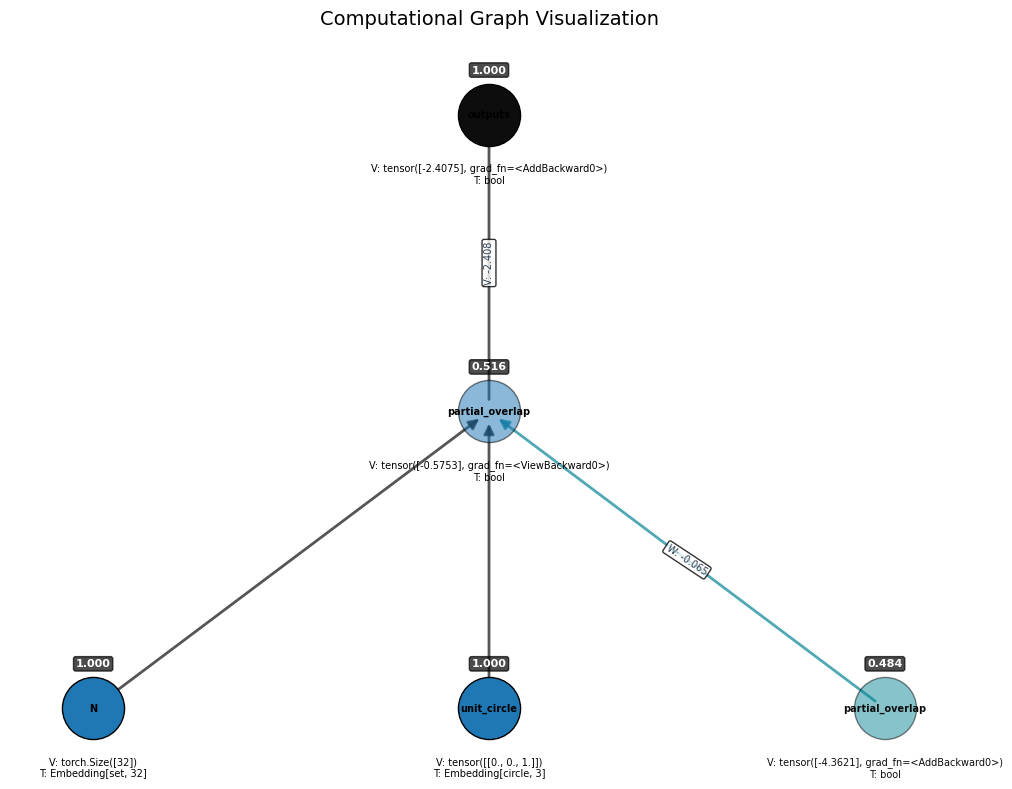

before training


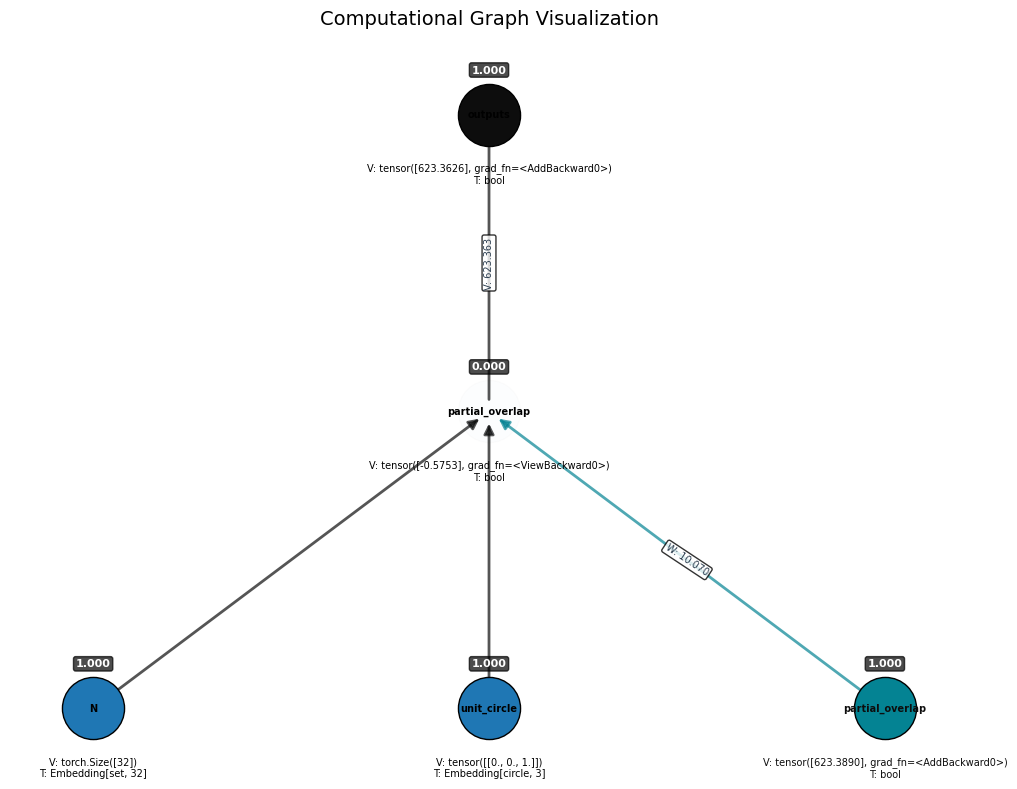

we are done here.


In [5]:

expr = "partial_overlap:Circle(N:Integer(), unit_circle:Circle())"
expr = Expression.parse_program_string(expr)

executor.base_executor.freeze_extended(False)
optim = torch.optim.Adam(executor.parameters(), lr = 1e-3)

executor.display("compute_tree_before")
print("before training")

for epoch in range(100):
    result = executor.evaluate(expr, grounding = {})
    loss = torch.nn.functional.binary_cross_entropy_with_logits(torch.tensor([1.0]), result.value)
    optim.zero_grad()
    loss.backward()
    optim.step()

executor.evaluate(expr, grounding = {})



executor.display("compute_tree_after")
print("we are done here.")


In [ ]:
from core.model import MetaLearner
from core.utils import stmetaphors
from helchriss.dsl.dsl_types import AnyType, BOOL

learner = MetaLearner([circle_executor, integer_executor])
learner.load_ckpt("outputs/checkpoints/sizer")
### load the meta learner from the pretrained-checkpoint

### check composition generalization of fixed lexicon entries
from core.grammar.lexicon import LexiconEntry, CCGSyntacticType, SemProgram, parse_from_string
def_entries = [
    LexiconEntry("red", 
                 CCGSyntacticType.syntatic_type_from_string("List[object]"),
                 parse_from_string("red:Objects(scene:Objects())") )
]


for entry in def_entries:print("entry:",entry)
learner.parser.purge_entry("red", p = 0.999, abs = False)
learner.parser.add_word_entries("red", def_entries)
learner.parser.display_word_entries("red")


query = "one plus red"
grounding = {}
#[print(entry) for entry in learner(query, grounding, tp = AnyType)[2]]
exprs = learner.parse_display(query, tp = BOOL, topK = 2,forced = 1)

exprs = learner.maximal_parse(query, forced = 1)[:2]
metas = learner.infer_metaphor_expressions([expr[0] for expr in exprs])

print(stmetaphors(metas))

learner.execute_display(query, grounding, topK = 6, forced = 1)
pass

29 16:10:42 WRN The input domain is empty, creating an empty domain
29 16:10:42 WRN The input domain is empty, creating an empty domain
29 16:10:42 WRN The input domain is empty, creating an empty domain
29 16:10:42 WRN The input domain is empty, creating an empty domain


entry: red : List[object] : red:Objects(scene:Objects()) : 0.000
+--------+--------------+------------------------------+----------+
| word   | type         | program                      |   weight |
+========+==============+==============================+==========+
| red    | List[object] | red:Objects(scene:Objects()) |        0 |
+--------+--------------+------------------------------+----------+
smaller:Integer(one:Integer(), red:Objects(scene:Objects())), 0.36
smaller:Integer(red:Objects(scene:Objects()), one:Integer()), 0.34


input types:
float
List[Tuple[bool, Embedding[object, 64]]]
True
True
output types:
float
float
input types:
float
List[Tuple[bool, Embedding[object, 64]]]
True
True
output types:
float
float
infering from 2 mismatch expressions
expression suggest an extention, but no short cut inferred.
plus of domain Integer defined on ['float', 'float'] might be extended to ['float', 'List[Tuple[bool, Embedding[object, 64]]]']

expression suggest an extention, but no s

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x292 and 651x64)

In [ ]:
 ### Display the Lexicon entries learned
for word in query.split(" "):
    learner.parser.display_word_entries(word)
    pass

+--------+-----------------------------------------------------------------------------------+---------------------------------+----------+
| word   | type                                                                              | program                         |   weight |
+========+===================================================================================+=================================+==========+
| one    | float/float/float                                                                 | λx0.x1.plus:Integer()           |  8.37867 |
+--------+-----------------------------------------------------------------------------------+---------------------------------+----------+
| one    | float\float\float                                                                 | λx0.x1.plus:Integer()           |  6.10212 |
+--------+-----------------------------------------------------------------------------------+---------------------------------+----------+
| one    | bool/List

In [ ]:
### Create Prototype of Meta Learner
#!python main.py --command=create_prototype

In [ ]:
#!python main.py --command=train_mcl --epochs=3500 --lr=5e-3 \
#    --load_model=summer --save_model=sizer --dataset_name=IntSum

# Grounding Concepts
MetaLearner can learn to ground concepts using various sources.

In [ ]:
### use the model to learn to grounding using vqa and descriptive sentence.

# Planning with Actions

In [ ]:
### this can perform planning with various concepts.

# Solving CCSP Config
solve a ccsp configuration using the `make ...` descripption. Also allowed to training etc.

In [ ]:
from core.spatial.energy_graph import PointEnergyMLP
from core.spatial.diffusion import samples, ScheduleLogLinear, training_loop


constraints = {
        "externally_connected": [3,3],
        "partial_overlap": [3,3],
        "equal": [3,3],
        "disconnected": [3,3],
        "tangential_proper_part": [3,3],
        "non_tangential_proper_part": [3,3],
        "tangential_proper_part_inverse": [3,3],
        "non_tangential_proper_part_inverse": [3,3]
    }

state_path = "outputs/checkpoints/circular_state.pth"
device = "mps"

model = PointEnergyMLP(constraints, dim = 3)
model.load_state_dict(torch.load(state_path, map_location = device))


from datasets.ccsprim.circles_data import get_constraint_dataset
loader = get_constraint_dataset()
schedule = ScheduleLogLinear(N=300, sigma_min=0.005, sigma_max=10)
#trainer  = training_loop(loader, model, schedule, epochs=3)
#losses   = [ns.loss.item() for ns in trainer]

batchsize = 4

cond = {"edges":[
    (0, 1, "partial_overlap"),
    (1, 2, "disconnected"),
    (0, 2, "disconnected"),
    (2, 3, "partial_overlap"ww)
    ]}
xt = torch.randn([1,batchsize,3]) 
*xt, x0  = samples(model, schedule.sample_sigmas(300), gam=2, cond = cond, batchsize = batchsize, xt = xt)

print("Solution:")
print(x0[0].cpu().detach().numpy())



SyntaxError: invalid syntax (146679432.py, line 35)

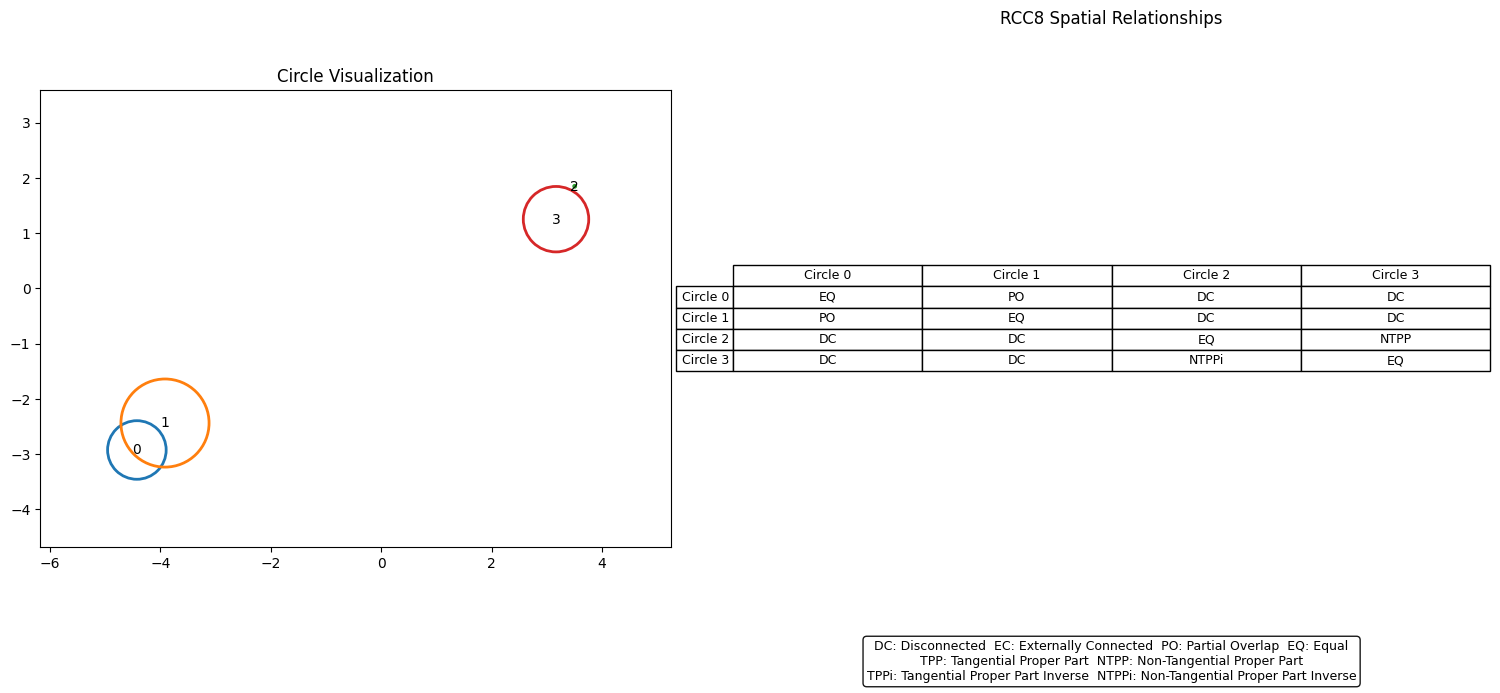

In [ ]:
from domains.spatial.circle_domain import circle_executor
circle_executor.visualize(x0[0].cpu())